In [25]:
# computation
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [249]:
def main(N, P, K, N_STEPS, N_DATASETS):
    """
    Main function to run the simulation

    Parameters
    ----------
    N : int
        Number of samples
    P : int
        Number of features
    K : int
        Number of folds
    N_STEPS : int
        Number of steps. Each step is a complete cross-validation
        So we will have N_STEPS * K estimates of the generalization
    N_DATASETS : int
        Number of datasets to simulate
    """
    df = pd.DataFrame()
    for i in range(N_DATASETS):
        df_trial = trial(N, P, K, N_STEPS)
        df_trial['dataset'] = i
        df = pd.concat([df, df_trial], ignore_index=True)

    df_tidy = df.melt(
                    id_vars=['step', 'dataset'], 
                    var_name='method', 
                    value_name='r2')
    return df_tidy

def trial(N, P, K, N_STEPS):
    """
    return a dataframe with N_STEPS * K estimates
    """
    X = np.random.randn(N, P)
    y = np.random.randn(N)

    dict_scores = {
        "MC": [None] * (N_STEPS * K), # monte carlo
        "CV": [None] * (N_STEPS * K), # cross-validation
    }

    for method in dict_scores.keys():
        i = 0
        for _ in range(N_STEPS):
            splits = Splitter(X, y, K).sample_splits(method)
            for k in range(K):
                r2 = estimate_g(
                    splits[k]['X_train'], 
                    splits[k]['y_train'], 
                    splits[k]['X_test'], 
                    splits[k]['y_test']
                )
                dict_scores[method][i] = r2
                i += 1
        dict_scores[method] = cum_avg(dict_scores[method])

    result = pd.DataFrame(data=dict_scores)
    result['step'] = result.index

    return result

class Splitter:
    def __init__(self, X, y, K):
        self.X = X
        self.y = y
        self.K = K
        self.n = X.shape[0]
        self.n_test = int((1 / K) * self.n)

    def sample_splits(self, method):
        if method == 'MC':
            dict_idx = self.sample_MC_idx()
        elif method == 'CV':
            dict_idx = self.sample_CV_idx()
        else:
            raise ValueError('Invalid method')

        return self.assign_splits(dict_idx)

    def sample_MC_idx(self):
        # monte carlo validation
        dict_idx = {}

        for k in range(self.K):
            dict_idx[k] = {}
            idx_rdm = np.random.permutation(self.n)
            dict_idx[k] = idx_rdm[:self.n_test]

        return dict_idx

    def sample_CV_idx(self):
        # cross-validation
        idx_rdm = np.random.permutation(self.n)
        dict_idx = np.array_split(idx_rdm, self.K)
        
        return dict_idx

    def assign_splits(self, dict_idx):
        dict_splits = {}
        set_idx = set(range(self.n))

        for k in range(self.K):
            dict_splits[k] = {}

            idx_test = dict_idx[k]
            idx_train = list(set_idx - set(idx_test))

            dict_splits[k]['X_train'] = self.X[idx_train]
            dict_splits[k]['X_test'] = self.X[idx_test]
            dict_splits[k]['y_train'] = self.y[idx_train]
            dict_splits[k]['y_test'] = self.y[idx_test]

        return dict_splits


def estimate_g(X_train, y_train, X_test, y_test):
    """
    Estimate generalization performance in correlation coefficient
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r, _ = pearsonr(y_test, y_pred)
    return r**2

def cum_avg(arr):
    """
    Calculate cumulative average
    """
    return np.cumsum(arr) / np.arange(1, len(arr) + 1)

def plotting(out):
    plt.figure(figsize=(10, 5))
    plt.axhline(np.mean(out["r2"]),  # mean estimates as converging point
                color='black', 
                linestyle='--', 
                linewidth=1,)
    sns.lineplot(
                data=out,
                x='step',
                y='r2', 
                hue='method',
                )
    plt.xlabel('Number of estimates')
    plt.ylabel('Bias in r2')
    plt.show()


In [254]:
# CONSTANTS
N = 100 # number of samples
P = 5 # number of features
K = 2 # number of folds
N_STEPS = 100 # we will have N_STEPS * K estimates per dataset
N_DATASETS = 50 # number of sampled datasets

out = main(N, P, K, N_STEPS, N_DATASETS)

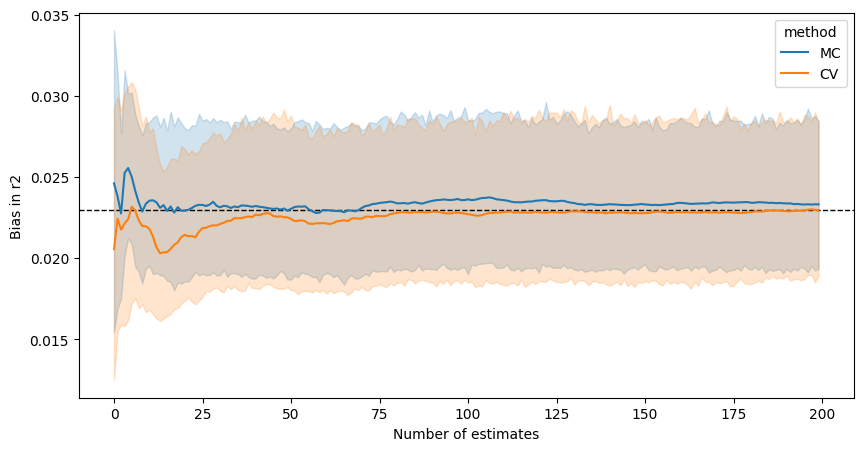

In [255]:
plotting(out)